# Understanding CMRR Multiband EPI Acquisition

This notebook analyzes the main **CMRR multiband EPI** acquisition used for fMRI. This is a 2D multi-slice acquisition with simultaneous multi-slice (SMS) acceleration.

## What to explore
- **Multiband/SMS factor**: Number of slices acquired simultaneously
- **Slice organization**: How slices are ordered and separated
- **Temporal dynamics**: Multiple volumes/timepoints
- **2D k-space structure**: Line-by-line acquisition for each slice
- **Parallel imaging**: In-plane acceleration (GRAPPA)

In [1]:
import twixtools
import matplotlib.pyplot as plt

print('Hello')
full_sub_file_path = '/lustre/disk/home/shared/cusacklab/foundcog-raw/participants/ICC_103A/meas_MID00039_FID94271_cmrr_SBep2d_se_AP_RDS.dat'
twix_raw = twixtools.read_twix(full_sub_file_path)
epi_map  = twixtools.map_twix(twix_raw)


Hello
Software version: VD/VE (!?)

Scan  0


100%|██████████| 63.4M/63.4M [00:00<00:00, 1.40GB/s]



Scan  1


100%|██████████| 830M/830M [00:01<00:00, 867MB/s] 



## Load TWIX Raw Data

Using `twixtools` to read Siemens raw MRI data (.dat file). This file contains two measurements:
1. **AdjCoilSens calibration scan** (twix_raw[0]) - analyzed in separate notebook
2. **Main multiband EPI acquisition** (twix_raw[1]) - focus of this notebook

In [2]:
# See name of files
import json
# print(json.dumps(twix_raw[1]['hdr'], indent=2))
print(twix_raw[0]['raidfile_hdr'])
print(twix_raw[1]['raidfile_hdr'])
#print(epi_map[0])

(38, 94270, 10240, 67503200, b'xxxxxxxxxxxxxxxxxxxxxxx', b'AdjCoilSens')
(39, 94271, 67513856, 871717312, b'xxxxxxxxxxxxxxxxxxxxxxx', b'cmrr_SBep2d_se_AP_RDS')


## Extract Acquisition Parameters for Main EPI Scan

The TWIX header contains detailed acquisition parameters. Here we extract from the **second measurement** (twix_raw[1]):
- **Field of View (FOV)**: Physical dimensions of the imaging volume
- **Voxel size**: Resolution in each dimension
- **Matrix size**: Number of k-space points
- **Multiband factor**: Number of simultaneously excited slices
- **Number of slices**: Total slices in the volume
- **Repetitions**: Number of volumes/timepoints

These parameters are stored in `MeasYaps` (Measurement Parameters) section of the header.

In [3]:
# Get voxel size and FOV from the MAIN EPI acquisition (second measurement)
hdr = twix_raw[1]['hdr']

# Look for slice information
slice_array = hdr['MeasYaps']['sSliceArray']
print("Slice Array Keys:", slice_array.keys())

print(slice_array)
# Get slice information
if 'asSlice' in slice_array:
    first_slice = slice_array['asSlice'][0]
    print("\nFirst Slice Info:")
    print("Keys:", first_slice.keys())
    
    # Read out FOV
    if 'dReadoutFOV' in first_slice:
        print(f"\nReadout FOV: {first_slice['dReadoutFOV']} mm")
    if 'dPhaseFOV' in first_slice:
        print(f"Phase FOV: {first_slice['dPhaseFOV']} mm")
    if 'dThickness' in first_slice:
        print(f"Slice Thickness: {first_slice['dThickness']} mm")

# Get k-space parameters
kspace = hdr['MeasYaps']['sKSpace']
print("\n\nK-Space Info:")
if 'lBaseResolution' in kspace:
    print(f"Base Resolution: {kspace['lBaseResolution']}")
if 'lPhaseEncodingLines' in kspace:
    print(f"Phase Encoding Lines: {kspace['lPhaseEncodingLines']}")

# Calculate voxel size
base_res = kspace.get('lBaseResolution', None)
phase_lines = kspace.get('lPhaseEncodingLines', None)
readout_fov = first_slice.get('dReadoutFOV', None)
phase_fov = first_slice.get('dPhaseFOV', None)
thickness = first_slice.get('dThickness', None)

if base_res and phase_lines and readout_fov and phase_fov and thickness:
    voxel_size_x = readout_fov / base_res
    voxel_size_y = phase_fov / phase_lines
    voxel_size_z = thickness
    print(f"\nCalculated Voxel Size:")
    print(f"  X (readout): {voxel_size_x:.3f} mm")
    print(f"  Y (phase): {voxel_size_y:.3f} mm")
    print(f"  Z (slice): {voxel_size_z:.3f} mm")

# Get multiband/SMS parameters
print("\n" + "="*80)
print("Multiband/SMS Parameters:")
print("="*80)

# Search for multiband factor
if 'lMultiBandFactor' in hdr['MeasYaps']:
    mb_factor = hdr['MeasYaps']['lMultiBandFactor']
    print(f"Multiband Factor: {mb_factor}")

# Get number of slices
if 'lSize' in slice_array:
    n_slices = slice_array['lSize']
    print(f"Number of Slices: {n_slices}")

# Get number of repetitions (volumes/timepoints)
if 'lRepetitions' in hdr['MeasYaps']:
    n_reps = hdr['MeasYaps']['lRepetitions']
    print(f"Number of Repetitions: {n_reps}")

# Check for in-plane acceleration
if 'sPat' in hdr['MeasYaps']:
    pat = hdr['MeasYaps']['sPat']
    if 'lAccelFactPE' in pat:
        print(f"In-plane acceleration (GRAPPA): {pat['lAccelFactPE']}")

Slice Array Keys: dict_keys(['lSize', 'lConc', 'ucMode', 'ucAnatomicalSliceMode', 'asSlice', 'alSliceAcqOrder', 'anAsc', 'anPos', 'sTSat'])
{'lSize': 36, 'lConc': 1, 'ucMode': 4, 'ucAnatomicalSliceMode': 4, 'asSlice': [{'dThickness': 3.0, 'dPhaseFOV': 192.0, 'dReadoutFOV': 192.0, 'dInPlaneRot': 0.10105456369, 'sPosition': {'dSag': -0.602469630213, 'dCor': -14.3441654678, 'dTra': -108.18416007}, 'sNormal': {'dSag': 0.000704774061, 'dCor': 0.0942440964, 'dTra': 0.9955488705}}, {'dThickness': 3.0, 'dPhaseFOV': 192.0, 'dReadoutFOV': 192.0, 'dInPlaneRot': 0.10105456369, 'sPosition': {'dSag': -0.600143875811, 'dCor': -14.0331599497, 'dTra': -104.898848797}, 'sNormal': {'dSag': 0.000704774061, 'dCor': 0.0942440964, 'dTra': 0.9955488705}}, {'dThickness': 3.0, 'dPhaseFOV': 192.0, 'dReadoutFOV': 192.0, 'dInPlaneRot': 0.10105456369, 'sPosition': {'dSag': -0.59781812141, 'dCor': -13.7221544316, 'dTra': -101.613537524}, 'sNormal': {'dSag': 0.000704774061, 'dCor': 0.0942440964, 'dTra': 0.9955488705}

## Explore Measurement Data Buffers (MDBs) for Main EPI

For the multiband EPI acquisition, each MDB entry contains:
- **Raw k-space data**: Complex values for each coil channel
- **Counters**: 
  - **cLin**: Phase encoding line
  - **cSlc**: Slice number
  - **cRep**: Repetition/volume/timepoint
  - **cSet**: Set counter (for multiband, indicates slice group)
- **Flags**: Indicate data type (image, noise, phase correction, etc.)

Note: For 2D EPI, cPar should be 0 (no partition encoding).

In [4]:
# Get all imaging MDbs from the MAIN EPI acquisition (twix_raw[1])
image_mdbs = [mdb for mdb in twix_raw[1]['mdb'] if mdb.is_image_scan()]

print(f"Total image MDbs in main EPI: {len(image_mdbs)}\n")

# Check the first several entries to understand the structure
print("Examining first 30 MDB entries:\n")
print("="*100)
print(f"{'MDB':<6} {'cLin':<6} {'cSlc':<6} {'cRep':<6} {'cSet':<6} {'cPar':<6} {'Channels':<10} {'Data Shape'}")
print("-" * 100)

for i in range(min(30, len(image_mdbs))):
    mdb = image_mdbs[i]
    n_channels = len(mdb.channel_hdr)
    data_shape = mdb.data.shape if hasattr(mdb.data, 'shape') else 'N/A'
    
    print(f"{i:<6} {mdb.cLin:<6} {mdb.cSlc:<6} {mdb.cRep:<6} {mdb.cSet:<6} {mdb.cPar:<6} {n_channels:<10} {data_shape}")

# Get unique values to understand the data structure
all_lins = [mdb.cLin for mdb in image_mdbs]
all_slcs = [mdb.cSlc for mdb in image_mdbs]
all_reps = [mdb.cRep for mdb in image_mdbs]
all_sets = [mdb.cSet for mdb in image_mdbs]

print("\n" + "="*100)
print("Data Structure Summary:")
print(f"  Unique line indices (cLin): {sorted(set(all_lins))[:10]}... (total: {len(set(all_lins))})")
print(f"  Unique slice indices (cSlc): {sorted(set(all_slcs))}")
print(f"  Unique repetitions (cRep): {sorted(set(all_reps))[:10]}... (total: {len(set(all_reps))})")
print(f"  Unique sets (cSet): {sorted(set(all_sets))}")
print(f"  Number of channels: {len(image_mdbs[0].channel_hdr)}")
print(f"  Readout points: {image_mdbs[0].data.shape[1]}")

Total image MDbs in main EPI: 23040

Examining first 30 MDB entries:

MDB    cLin   cSlc   cRep   cSet   cPar   Channels   Data Shape
----------------------------------------------------------------------------------------------------
0      0      0      0      0      0      34         (34, 128)
1      1      0      0      0      0      34         (34, 128)
2      2      0      0      0      0      34         (34, 128)
3      3      0      0      0      0      34         (34, 128)
4      4      0      0      0      0      34         (34, 128)
5      5      0      0      0      0      34         (34, 128)
6      6      0      0      0      0      34         (34, 128)
7      7      0      0      0      0      34         (34, 128)
8      8      0      0      0      0      34         (34, 128)
9      9      0      0      0      0      34         (34, 128)
10     10     0      0      0      0      34         (34, 128)
11     11     0      0      0      0      34         (34, 128)
12     12

## Check for Reference Scans

Let's examine all MDB entries to see if there are reference/navigator scans for ghost correction.

In [5]:
# Check all MDB types in the EPI acquisition
all_mdbs = twix_raw[1]['mdb']
print(f"Total MDB entries: {len(all_mdbs)}\n")

# Categorize MDbs by scan type
image_scans = []
ref_scans = []
noise_scans = []
other_scans = []

for mdb in all_mdbs:
    if mdb.is_image_scan():
        image_scans.append(mdb)
    elif hasattr(mdb, 'is_ref_scan') and mdb.is_ref_scan():
        ref_scans.append(mdb)
    elif hasattr(mdb, 'is_noise_scan') and mdb.is_noise_scan():
        noise_scans.append(mdb)
    else:
        other_scans.append(mdb)

print(f"Image scans: {len(image_scans)}")
print(f"Reference scans: {len(ref_scans)}")
print(f"Noise scans: {len(noise_scans)}")
print(f"Other scans: {len(other_scans)}")

# Check eval_info flags for reference scans
if len(ref_scans) > 0:
    print(f"\n{'='*80}")
    print("Reference Scans Found!")
    print(f"{'='*80}")
    print(f"\nExamining first {min(10, len(ref_scans))} reference scans:")
    print(f"{'MDB':<6} {'cLin':<6} {'cSlc':<6} {'cRep':<6} {'Channels':<10} {'Data Shape'}")
    print("-" * 70)
    for i in range(min(10, len(ref_scans))):
        mdb = ref_scans[i]
        n_channels = len(mdb.channel_hdr)
        data_shape = mdb.data.shape if hasattr(mdb.data, 'shape') else 'N/A'
        print(f"{i:<6} {mdb.cLin:<6} {mdb.cSlc:<6} {mdb.cRep:<6} {n_channels:<10} {data_shape}")
else:
    print("\nNo reference scans found with is_ref_scan() flag")
    
# Also check eval_info_mask flags directly
print(f"\n{'='*80}")
print("Checking eval_info_mask flags on first 50 MDbs:")
print(f"{'='*80}")

flag_summary = {}
for i, mdb in enumerate(all_mdbs[:50]):
    if hasattr(mdb, 'eval_info_mask'):
        mask = mdb.eval_info_mask
        key = f"mask_{mask}"
        if key not in flag_summary:
            flag_summary[key] = []
        flag_summary[key].append(i)

for key, indices in sorted(flag_summary.items()):
    print(f"{key}: indices {indices[:10]}{'...' if len(indices) > 10 else ''} (count: {len(indices)})")

Total MDB entries: 24120

Image scans: 23040
Reference scans: 0
Noise scans: 0
Other scans: 1080

No reference scans found with is_ref_scan() flag

Checking eval_info_mask flags on first 50 MDbs:
Image scans: 23040
Reference scans: 0
Noise scans: 0
Other scans: 1080

No reference scans found with is_ref_scan() flag

Checking eval_info_mask flags on first 50 MDbs:


In [6]:
# Investigate the "other" scans more closely
print(f"\n{'='*80}")
print(f"Investigating {len(other_scans)} 'other' scans")
print(f"{'='*80}\n")

# Check first 20 other scans
print(f"First 20 'other' scans:")
print(f"{'MDB':<6} {'cLin':<6} {'cSlc':<6} {'cRep':<6} {'cPar':<6} {'Channels':<10} {'Data Shape':<15} {'is_flag_set'}")
print("-" * 100)

for i in range(min(20, len(other_scans))):
    mdb = other_scans[i]
    n_channels = len(mdb.channel_hdr) if hasattr(mdb, 'channel_hdr') else 'N/A'
    data_shape = str(mdb.data.shape) if hasattr(mdb.data, 'shape') else 'N/A'
    
    # Check various flags
    flags = []
    if hasattr(mdb, 'is_ref_scan') and mdb.is_ref_scan():
        flags.append('REF')
    if hasattr(mdb, 'is_phase_corr_scan') and mdb.is_phase_corr_scan():
        flags.append('PHASECOR')
    if hasattr(mdb, 'is_ref_phase_corr_scan') and mdb.is_ref_phase_corr_scan():
        flags.append('REFPHASECOR')
    if hasattr(mdb, 'is_noise_scan') and mdb.is_noise_scan():
        flags.append('NOISE')
    if hasattr(mdb, 'is_rtfeedback_scan') and mdb.is_rtfeedback_scan():
        flags.append('RTFEED')
    if hasattr(mdb, 'is_hp_feedback_scan') and mdb.is_hp_feedback_scan():
        flags.append('HPFEED')
    
    flag_str = ','.join(flags) if flags else 'none'
    
    print(f"{i:<6} {mdb.cLin:<6} {mdb.cSlc:<6} {mdb.cRep:<6} {mdb.cPar:<6} {n_channels:<10} {data_shape:<15} {flag_str}")

# Check if they're phase correction scans
phase_corr_scans = [mdb for mdb in other_scans if hasattr(mdb, 'is_phase_corr_scan') and mdb.is_phase_corr_scan()]
print(f"\n{'='*80}")
print(f"Phase correction scans found: {len(phase_corr_scans)}")
print(f"{'='*80}")

if len(phase_corr_scans) > 0:
    print(f"\nThese are likely the reference scans for EPI ghost correction!")
    print(f"\nStructure of phase correction scans:")
    
    # Analyze structure
    pc_lins = [mdb.cLin for mdb in phase_corr_scans]
    pc_slcs = [mdb.cSlc for mdb in phase_corr_scans]
    pc_reps = [mdb.cRep for mdb in phase_corr_scans]
    
    print(f"  Lines per scan: {len(set(pc_lins))}")
    print(f"  Slices covered: {len(set(pc_slcs))}")
    print(f"  Repetitions: {len(set(pc_reps))}")
    print(f"  Channels: {len(phase_corr_scans[0].channel_hdr)}")
    print(f"  Data shape: {phase_corr_scans[0].data.shape}")


Investigating 1080 'other' scans

First 20 'other' scans:
MDB    cLin   cSlc   cRep   cPar   Channels   Data Shape      is_flag_set
----------------------------------------------------------------------------------------------------
0      32     0      0      0      34         (34, 128)       none
1      32     0      0      0      34         (34, 128)       none
2      32     0      0      0      34         (34, 128)       none
3      32     1      0      0      34         (34, 128)       none
4      32     1      0      0      34         (34, 128)       none
5      32     1      0      0      34         (34, 128)       none
6      32     2      0      0      34         (34, 128)       none
7      32     2      0      0      34         (34, 128)       none
8      32     2      0      0      34         (34, 128)       none
9      32     3      0      0      34         (34, 128)       none
10     32     3      0      0      34         (34, 128)       none
11     32     3      0      0

In [7]:
# The "other" scans have cLin=32 which is outside the image matrix (0-63)
# These could be the ACS (auto-calibration signal) lines for GRAPPA or reference lines for ghost correction

print(f"\n{'='*80}")
print("Analyzing 'other' scans with cLin=32")
print(f"{'='*80}\n")

# Group by slice and repetition
from collections import defaultdict
ref_by_slice_rep = defaultdict(list)

for mdb in other_scans:
    key = (mdb.cSlc, mdb.cRep)
    ref_by_slice_rep[key].append(mdb)

print(f"Total slice-rep combinations with reference lines: {len(ref_by_slice_rep)}")
print(f"Reference lines per slice-rep combination: {len(ref_by_slice_rep[(0, 0)])}")

# Check a few
print(f"\nExample: Slice 0, Rep 0 has {len(ref_by_slice_rep[(0, 0)])} reference lines")
print(f"Example: Slice 18, Rep 5 has {len(ref_by_slice_rep[(18, 5)])} reference lines")

# These are likely reference lines acquired with the same readout
# Let's extract them and see if we can use them for ghost correction
print(f"\n{'='*80}")
print("These appear to be reference/navigator lines!")
print("3 lines per slice suggest: positive polarity, negative polarity, and possibly a baseline")
print(f"{'='*80}")

# Let's look at the actual data
print(f"\nData characteristics:")
print(f"  Shape: {other_scans[0].data.shape} (channels × readout)")
print(f"  Data type: {other_scans[0].data.dtype}")
print(f"  Example magnitude range: {np.abs(other_scans[0].data).min():.2e} to {np.abs(other_scans[0].data).max():.2e}")

# Check if these are acquired with different polarities
print(f"\nChecking signal characteristics of the 3 reference lines for slice 0:")
for i in range(3):
    mdb = ref_by_slice_rep[(0, 0)][i]
    mean_signal = np.mean(np.abs(mdb.data))
    print(f"  Reference line {i}: mean magnitude = {mean_signal:.2e}")


Analyzing 'other' scans with cLin=32

Total slice-rep combinations with reference lines: 360
Reference lines per slice-rep combination: 3

Example: Slice 0, Rep 0 has 3 reference lines
Example: Slice 18, Rep 5 has 3 reference lines

These appear to be reference/navigator lines!
3 lines per slice suggest: positive polarity, negative polarity, and possibly a baseline

Data characteristics:
  Shape: (34, 128) (channels × readout)
  Data type: complex64


NameError: name 'np' is not defined

## Extract and Organize Reference Lines for Ghost Correction

In [10]:
# Organize reference lines into array: [reps, slices, ref_lines, channels, readout]
n_ref_lines = 3  # 3 reference lines per slice

ref_lines = np.zeros([n_rep, n_slc, n_ref_lines, n_channels, n_col], dtype=np.complex64)

# Fill reference line array
for mdb in other_scans:
    rep_idx = mdb.cRep
    slc_idx = mdb.cSlc
    
    # Determine which of the 3 reference lines this is
    # They appear in order for each slice, so we can count
    # Find how many we've already filled for this rep/slice
    filled_count = np.sum(np.abs(ref_lines[rep_idx, slc_idx, :, 0, 0]) > 0)
    
    if filled_count < n_ref_lines:
        ref_lines[rep_idx, slc_idx, filled_count, :, :] = mdb.data

print(f"Reference lines array shape: {ref_lines.shape}")
print(f"[repetitions, slices, ref_lines, channels, readout]")
print(f"Successfully extracted {n_rep} × {n_slc} × {n_ref_lines} reference lines")

Reference lines array shape: (10, 36, 3, 34, 128)
[repetitions, slices, ref_lines, channels, readout]
Successfully extracted 10 × 36 × 3 reference lines


## Extract Slice Positions for Spatial Ordering

Check the slice position information to order slices by their spatial location.

In [23]:
# Extract slice positions from header
slice_positions = []

# Check if we have position information for each slice
if 'asSlice' in slice_array:
    for i, slice_info in enumerate(slice_array['asSlice']):
        if 'sPosition' in slice_info:
            pos = slice_info['sPosition']
            # Position is typically given in scanner coordinates (Sag, Cor, Tra)
            # We'll use all three coordinates, but one will dominate for ordering
            slice_positions.append({
                'original_index': i,
                'sag': pos.get('dSag', 0.0),
                'cor': pos.get('dCor', 0.0), 
                'tra': pos.get('dTra', 0.0)
            })

print(f"Found {len(slice_positions)} slice positions")
print(f"\nFirst few slice positions:")
for i in range(min(5, len(slice_positions))):
    sp = slice_positions[i]
    print(f"  Slice {i}: Sag={sp['sag']:.1f}, Cor={sp['cor']:.1f}, Tra={sp['tra']:.1f} mm")

# Determine the primary slice direction by checking which coordinate varies most
if len(slice_positions) > 1:
    sag_range = max([s['sag'] for s in slice_positions]) - min([s['sag'] for s in slice_positions])
    cor_range = max([s['cor'] for s in slice_positions]) - min([s['cor'] for s in slice_positions])
    tra_range = max([s['tra'] for s in slice_positions]) - min([s['tra'] for s in slice_positions])
    
    print(f"\nSlice position ranges:")
    print(f"  Sagittal: {sag_range:.1f} mm")
    print(f"  Coronal: {cor_range:.1f} mm")
    print(f"  Transverse: {tra_range:.1f} mm")
    
    # Determine primary direction
    if sag_range >= cor_range and sag_range >= tra_range:
        primary_dir = 'sag'
        print(f"\nPrimary slice direction: SAGITTAL")
    elif cor_range >= tra_range:
        primary_dir = 'cor'
        print(f"\nPrimary slice direction: CORONAL")
    else:
        primary_dir = 'tra'
        print(f"\nPrimary slice direction: TRANSVERSE/AXIAL")
    
    # The MDB and header already store slices in SPATIAL order (confirmed by 3.3mm spacing)
    # But the ACQUISITION was interleaved
    # So MDB indices 0,1,2,... are spatial positions 0,1,2,... 
    # We need to create spatial_order for display (which is just 0,1,2,...)
    spatial_order = list(range(len(slice_positions)))
    
    print(f"\n{'='*70}")
    print("IMPORTANT: MDB indices are already in SPATIAL order")
    print("="*70)
    print(f"MDB index 0,1,2,...35 = Spatial order inferior->superior")
    print(f"\nBut the ACQUISITION was interleaved (even then odd):")
    print(f"  Time 1: acquired slices 0,2,4,...,34 (even, spatially distributed)")
    print(f"  Time 2: acquired slices 1,3,5,...,35 (odd, filling gaps)")
    print(f"\nFor visualization: display in MDB order = spatial order")
else:
    print("\nNot enough slices to determine ordering")
    spatial_order = list(range(len(slice_positions)))
    slice_to_spatial = {i: i for i in range(len(slice_positions))}

Found 36 slice positions

First few slice positions:
  Slice 0: Sag=-0.6, Cor=-14.3, Tra=-108.2 mm
  Slice 1: Sag=-0.6, Cor=-14.0, Tra=-104.9 mm
  Slice 2: Sag=-0.6, Cor=-13.7, Tra=-101.6 mm
  Slice 3: Sag=-0.6, Cor=-13.4, Tra=-98.3 mm
  Slice 4: Sag=-0.6, Cor=-13.1, Tra=-95.0 mm

Slice position ranges:
  Sagittal: 0.1 mm
  Coronal: 10.9 mm
  Transverse: 115.0 mm

Primary slice direction: TRANSVERSE/AXIAL

IMPORTANT: MDB indices are already in SPATIAL order
MDB index 0,1,2,...35 = Spatial order inferior->superior

But the ACQUISITION was interleaved (even then odd):
  Time 1: acquired slices 0,2,4,...,34 (even, spatially distributed)
  Time 2: acquired slices 1,3,5,...,35 (odd, filling gaps)

For visualization: display in MDB order = spatial order


In [22]:
# Look at the actual positions to see the interleaving
print(f"\nSlice positions in MDB order (showing interleaving):")
print("="*70)
print(f"{'MDB Idx':<10} {'Tra Pos (mm)':<15} {'Pattern'}")
print("-"*70)

for i in range(len(slice_positions)):
    tra_pos = slice_positions[i]['tra']
    print(f"{i:<10} {tra_pos:>10.1f}")
    
# Check the spacing pattern
print(f"\n{'='*70}")
print("Checking spacing between consecutive MDB slices:")
for i in range(min(10, len(slice_positions)-1)):
    tra_diff = slice_positions[i+1]['tra'] - slice_positions[i]['tra']
    print(f"  MDB {i} to {i+1}: {tra_diff:6.1f} mm")

print(f"\nIf slices are interleaved, we should see large jumps (not ~3.3mm)")
print(f"For 36 slices over 115mm, sequential spacing would be ~3.3mm")
print(f"For interleaved, we'd see ~6.6mm jumps")


Slice positions in MDB order (showing interleaving):
MDB Idx    Tra Pos (mm)    Pattern
----------------------------------------------------------------------
0              -108.2
1              -104.9
2              -101.6
3               -98.3
4               -95.0
5               -91.8
6               -88.5
7               -85.2
8               -81.9
9               -78.6
10              -75.3
11              -72.0
12              -68.8
13              -65.5
14              -62.2
15              -58.9
16              -55.6
17              -52.3
18              -49.0
19              -45.8
20              -42.5
21              -39.2
22              -35.9
23              -32.6
24              -29.3
25              -26.1
26              -22.8
27              -19.5
28              -16.2
29              -12.9
30               -9.6
31               -6.3
32               -3.1
33                0.2
34                3.5
35                6.8

Checking spacing between consecutive MDB slices

## Understanding Multiband EPI Data Organization

For multiband EPI:
- **cLin**: Cycles through phase encoding lines (e.g., 0-63 for 64 lines)
- **cSlc**: Slice number (after multiband unfolding)
- **cRep**: Volume/timepoint in the timeseries
- **cSet**: May indicate the multiband slice group or acquisition set
- **cPar**: Should be 0 for 2D acquisition (no 3rd dimension encoding)

The key question: How are the simultaneously acquired slices organized?

## Build 4D K-space Array for EPI Timeseries

For the multiband EPI, we need to organize k-space as:
**[repetitions, slices, lines, channels, readout points]**

This allows us to reconstruct each slice at each timepoint.

In [9]:
# Build 4D k-space array for EPI data
import numpy as np
from numpy.fft import fftshift, ifftshift, ifftn, fftn, ifft2, fft2

# Determine dimensions from the MDbs
n_lin = 1 + max([mdb.cLin for mdb in image_mdbs])
n_slc = 1 + max([mdb.cSlc for mdb in image_mdbs])
n_rep = 1 + max([mdb.cRep for mdb in image_mdbs])
n_channels = len(image_mdbs[0].channel_hdr)
n_col = image_mdbs[0].data.shape[1]

print(f"K-space dimensions:")
print(f"  Repetitions (volumes): {n_rep}")
print(f"  Slices: {n_slc}")
print(f"  Phase encoding lines: {n_lin}")
print(f"  Channels: {n_channels}")
print(f"  Readout points: {n_col}")

# Create k-space array: [reps, slices, lines, channels, readout]
kspace_epi = np.zeros([n_rep, n_slc, n_lin, n_channels, n_col], dtype=np.complex64)

# Fill k-space
print(f"\nFilling k-space array...")
for mdb in image_mdbs:
    kspace_epi[mdb.cRep, mdb.cSlc, mdb.cLin, :, :] = mdb.data

print(f"K-space shape: {kspace_epi.shape}")
print(f"K-space filled!")

K-space dimensions:
  Repetitions (volumes): 10
  Slices: 36
  Phase encoding lines: 64
  Channels: 34
  Readout points: 128

Filling k-space array...
K-space shape: (10, 36, 64, 34, 128)
K-space filled!
K-space shape: (10, 36, 64, 34, 128)
K-space filled!


## Reconstruct EPI Images

For 2D EPI, we use 2D inverse FFT (over phase and readout dimensions) for each slice and timepoint.

## EPI Phase Correction

EPI sequences acquire alternating lines in opposite directions (odd/even lines). This causes Nyquist ghosting artifacts that need phase correction.

In [11]:
import numpy as np

def correct_nyquist_ghost(kspace, ref_lines):
    """
    Apply EPI Nyquist ghost correction using 3 reference scans (Navigators).
    
    Parameters:
    -----------
    kspace : ndarray
        K-space data with shape [n_lin, n_channels, n_col] (complex)
    ref_lines : ndarray
        Reference line data with shape [3, n_channels, n_col] (complex)
        Expected order:
        Ref 0: Positive gradient (same as even lines)
        Ref 1: Negative gradient (same as odd lines)
        Ref 2: Positive gradient (same as even lines)
    
    Returns:
    --------
    kspace_corrected : ndarray
        Ghost-corrected k-space data
    """
    n_lin, n_channels, n_col = kspace.shape
    n_ref, _, _ = ref_lines.shape
    
    if n_ref < 3:
        raise ValueError(f"Expected 3 reference lines, got {n_ref}")

    kspace_corrected = kspace.copy()
    
    # 1. Reverse odd lines in kspace and the negative reference line (idx 1)
    #    EPI acquisitions typically flip the readout gradient for odd lines.
    #    We flip the data so everything is in the same direction before FFT.
    #    (Note: Some scanners/recon pipelines might do this early, but raw usually implies we need to do it)
    
    # Flip odd k-space lines (1, 3, 5...)
    kspace_corrected[1::2, :, :] = kspace_corrected[1::2, :, ::-1]
    
    # Flip the negative reference line (index 1) which corresponds to odd k-space lines
    ref_lines_proc = ref_lines.copy()
    ref_lines_proc[1, :, :] = ref_lines_proc[1, :, ::-1]
    
    # 2. Estimate Phase Error
    # Average the two positive reference lines (0 and 2) to match the center time of line 1
    ref_pos = (ref_lines_proc[0] + ref_lines_proc[2]) / 2.0
    ref_neg = ref_lines_proc[1]
    
    # Iterate over channels to find phase difference
    for ch in range(n_channels):
        # Extract single channel references
        # Avoid division by zero
        r_p = ref_pos[ch]
        r_n = ref_neg[ch]
        
        # Mask out low signal areas for robust phase estimation
        # (Optional but good practice: simple magnitude threshold)
        mag = (np.abs(r_p) + np.abs(r_n)) / 2
        mask = mag > (0.1 * np.max(mag))
        
        if np.sum(mask) < 10:
             # Fallback if signal is too low (noise scan?)
            continue
            
        # Compute phase difference: angle(ref_pos / ref_neg)
        # We want to align odd (neg) to even (pos) or vice versa.
        # Let's say we want to align NEG (odd) to match POS (even).
        # Diff = angle(Ref_Pos) - angle(Ref_Neg)
        # Correction for Odd = exp(+j * Diff)
        
        # Cross product angle calculation is robust: angle(A * conj(B)) = angle(A) - angle(B)
        phase_diff_ch = np.angle(r_p * np.conj(r_n))
        
        # Unwrap phase along the readout direction
        phase_unwrapped = np.unwrap(phase_diff_ch)
        
        # Fit linear model: phase_err(k) = alpha + beta * k
        # This corresponds to:
        # alpha: Constant phase offset (0th order)
        # beta:  Group delay / shift (1st order)
        # We only fit where signal is significant
        x_indices = np.arange(n_col)
        
        # Weighted simple linear regression or just fit on mask
        if np.any(mask):
            try:
                poly = np.polyfit(x_indices[mask], phase_unwrapped[mask], 1)
                phase_fit = np.polyval(poly, x_indices)
            except:
                 phase_fit = np.zeros(n_col)
        else:
            phase_fit = np.zeros(n_col)
            
        # 3. Apply Correction
        # We model the error as being split between odd and even or fully on one.
        # Commonly for EPI:
        # Even lines (0, 2...) are assumed "correct" (or reference).
        # Odd lines (1, 3...) are shifted.
        # We shift Odd lines by exp(j * phase_fit) to align with Even.
        
        correction_factor = np.exp(1j * phase_fit)
        
        # Apply only to odd lines for this channel
        kspace_corrected[1::2, ch, :] *= correction_factor

    return kspace_corrected 


In [12]:
def ifft2(kspace):
    """2D inverse FFT along first and last dimensions (phase and readout)"""
    # kspace has shape [n_lin, n_channels, n_col]
    # Apply FFT to phase (axis 0) and readout (axis 2) dimensions
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(kspace, axes=(0, 2)), axes=(0, 2)), axes=(0, 2))

def rms_comb(img, axis=1):
    """Root-mean-square coil combination"""
    return np.sqrt(np.sum(np.abs(img)**2, axis=axis))

In [14]:
# Reconstruct all timepoints and slices with phase correction
# Apply EPI phase correction, then 2D FFT, then combine coils
img_epi = np.zeros((n_rep, n_slc, n_lin, n_col), dtype=complex)

print("Reconstructing with reference-based ghost correction...")
for rep in range(n_rep):
    for slc in range(n_slc):
        # Get reference lines for this slice and repetition
        refs = ref_lines[rep, slc, :, :, :]  # [n_ref_lines, n_channels, n_col]
        
        # Apply EPI ghost correction using reference scans
        kspace_corrected = correct_nyquist_ghost(kspace_epi[rep, slc, :, :, :], refs)
        
        # 2D FFT over phase encode (lin) and readout (col) dimensions
        img_coils = ifft2(kspace_corrected)  # [n_lin, n_channels, n_col]
        
        # RMS coil combination
        img_epi[rep, slc, :, :] = rms_comb(img_coils)  # [n_lin, n_col]

print(f"Reconstructed EPI image shape: {img_epi.shape}")
print(f"Dimensions: [repetitions={n_rep}, slices={n_slc}, phase_lines={n_lin}, readout={n_col}]")

Reconstructing with reference-based ghost correction...
Reconstructed EPI image shape: (10, 36, 64, 128)
Dimensions: [repetitions=10, slices=36, phase_lines=64, readout=128]
Reconstructed EPI image shape: (10, 36, 64, 128)
Dimensions: [repetitions=10, slices=36, phase_lines=64, readout=128]


## Visualize EPI Slices

Show all slices from the first timepoint to understand spatial coverage.

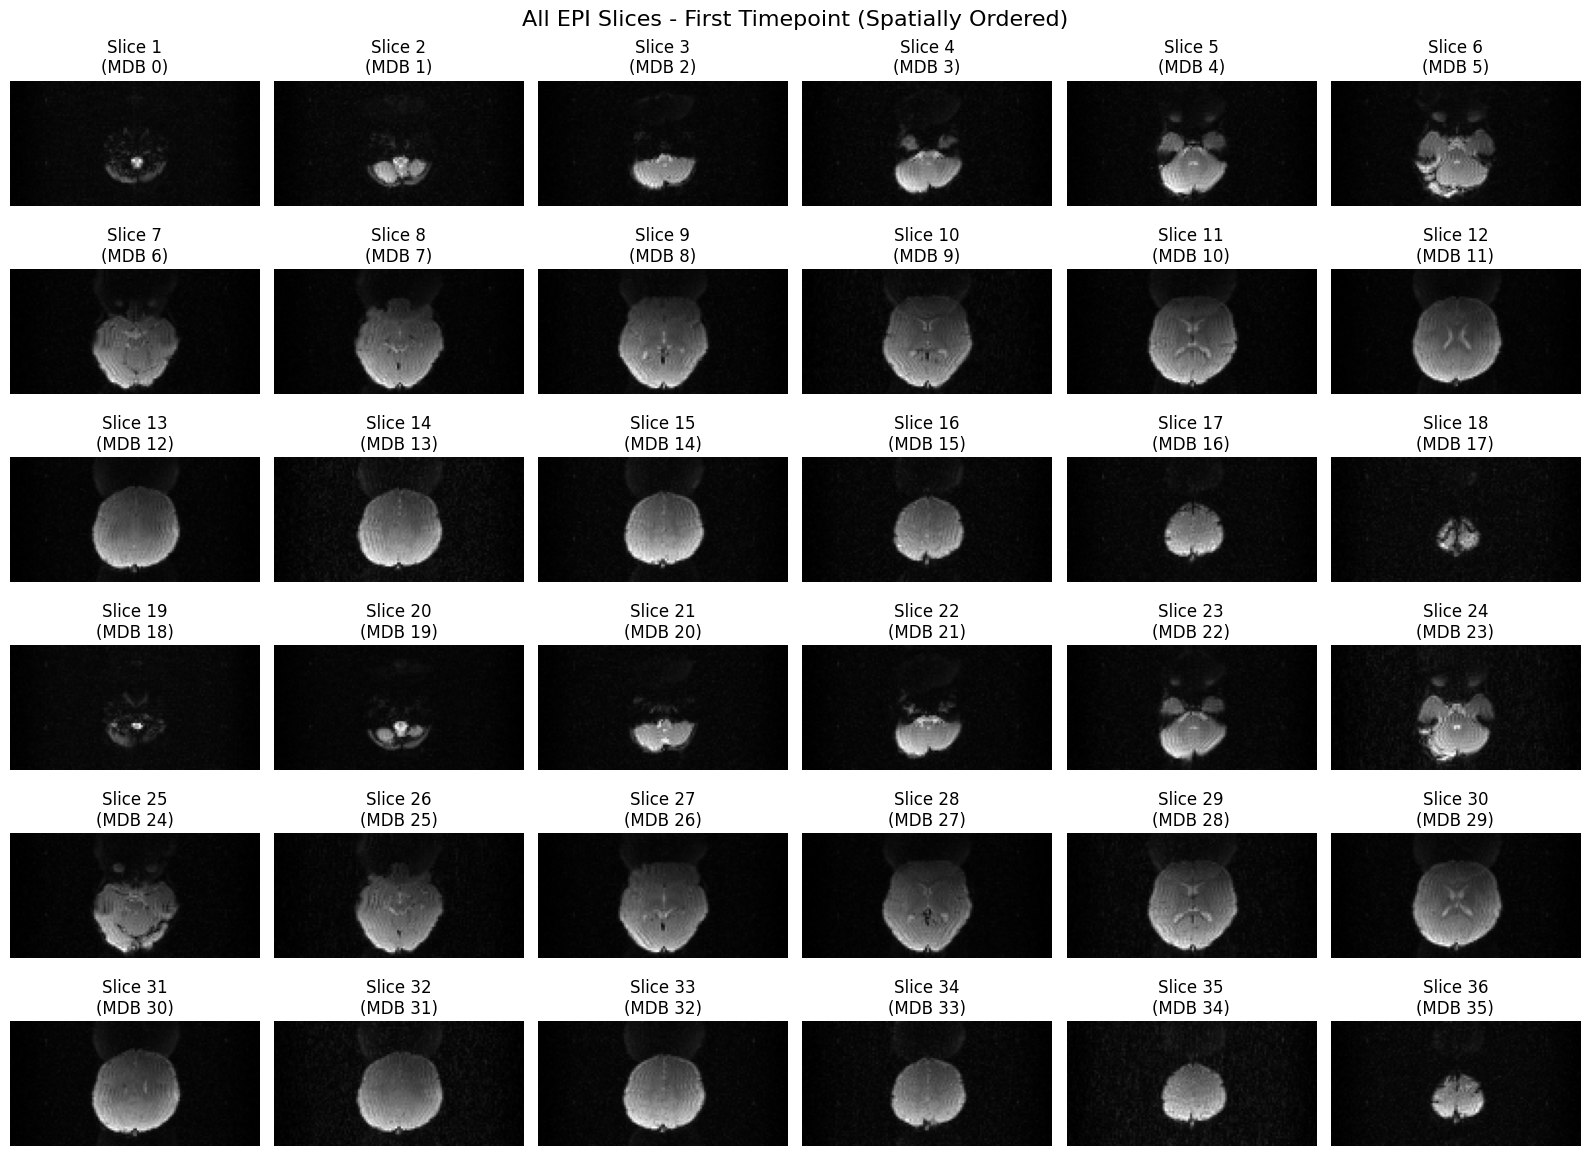

In [21]:
# Display all slices from first timepoint in a grid, ordered by spatial position
n_rows = int(np.ceil(np.sqrt(n_slc)))
n_cols = int(np.ceil(n_slc / n_rows))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 12))
axes = axes.flatten() if n_slc > 1 else [axes]

# Display in spatial order
for display_idx in range(n_slc):
    # Get the MDB slice index that corresponds to this spatial position
    mdb_slice_idx = spatial_order[display_idx]
    
    # Get the image for this slice
    img_slice = np.abs(img_epi[0, mdb_slice_idx, :, :])
    axes[display_idx].imshow(img_slice, cmap='gray', origin='lower')
    axes[display_idx].set_title(f'Slice {display_idx+1}\n(MDB {mdb_slice_idx})')
    axes[display_idx].axis('off')

# Hide unused subplots
for i in range(n_slc, len(axes)):
    axes[i].axis('off')

plt.suptitle('All EPI Slices - First Timepoint (Spatially Ordered)', fontsize=16)
plt.tight_layout()
plt.show()

## Timeseries Analysis

EPI acquires the same slices repeatedly over time. Let's examine the temporal dimension.

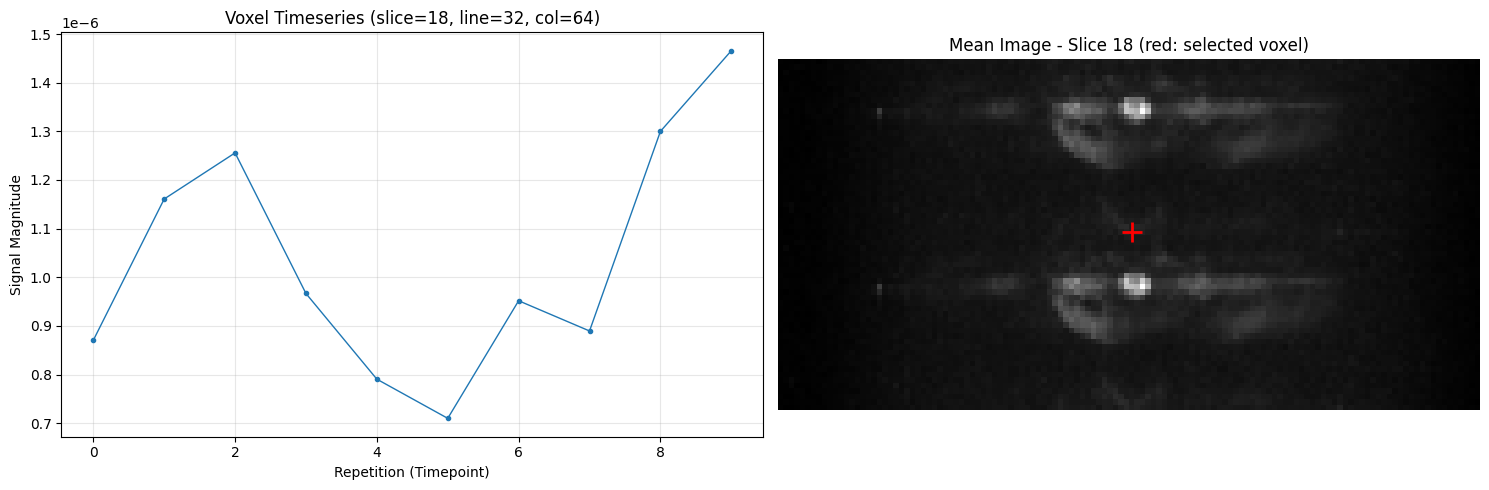

Signal range: 0.00 to 0.00
Mean signal: 0.00, Std: 0.00


In [ ]:
# Show temporal evolution of a single voxel
# Pick a voxel near the center
mid_lin = n_lin // 2
mid_col = n_col // 2
mid_slc = n_slc // 2

# Extract timeseries for this voxel
voxel_timeseries = np.abs(img_epi[:, mid_slc, mid_lin, mid_col])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot timeseries
ax1.plot(voxel_timeseries, marker='o', linewidth=1, markersize=3)
ax1.set_xlabel('Repetition (Timepoint)')
ax1.set_ylabel('Signal Magnitude')
ax1.set_title(f'Voxel Timeseries (slice={mid_slc}, line={mid_lin}, col={mid_col})')
ax1.grid(True, alpha=0.3)

# Show mean image across all timepoints for reference
mean_img = np.mean(np.abs(img_epi[:, mid_slc, :, :]), axis=0)
ax2.imshow(mean_img, cmap='gray', origin='lower')
ax2.plot(mid_col, mid_lin, 'r+', markersize=15, markeredgewidth=2)
ax2.set_title(f'Mean Image - Slice {mid_slc} (red: selected voxel)')
ax2.axis('off')

plt.tight_layout()
plt.show()

print(f"Signal range: {voxel_timeseries.min():.2f} to {voxel_timeseries.max():.2f}")
print(f"Mean signal: {voxel_timeseries.mean():.2f}, Std: {voxel_timeseries.std():.2f}")

## Temporal SNR Map

Temporal signal-to-noise ratio (tSNR) is the mean signal divided by standard deviation over time. Higher tSNR indicates more stable signal.

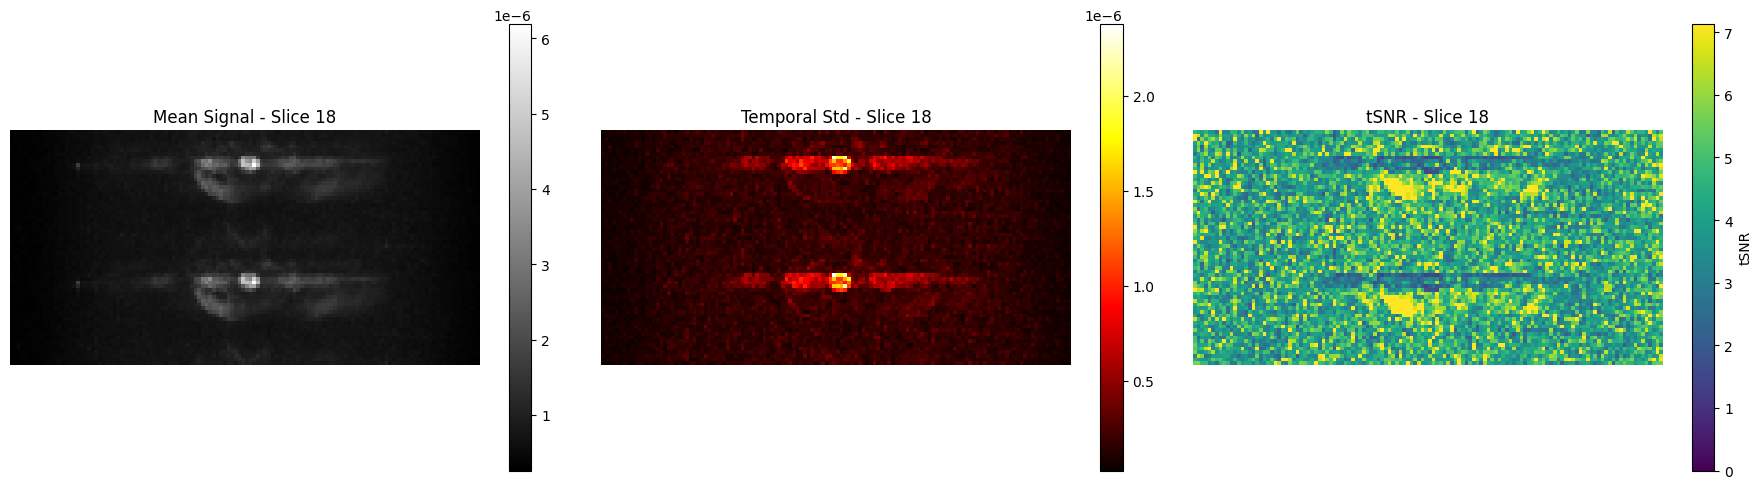

Mean tSNR: 7.46
Median tSNR: 5.54


In [ ]:
# Calculate tSNR for each voxel
mean_over_time = np.mean(np.abs(img_epi), axis=0)  # [n_slc, n_lin, n_col]
std_over_time = np.std(np.abs(img_epi), axis=0)    # [n_slc, n_lin, n_col]

# Avoid division by zero
tsnr = np.where(std_over_time > 0, mean_over_time / std_over_time, 0)

# Display tSNR for middle slice
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Mean image
im1 = ax1.imshow(mean_over_time[mid_slc, :, :], cmap='gray', origin='lower')
ax1.set_title(f'Mean Signal - Slice {mid_slc}')
ax1.axis('off')
plt.colorbar(im1, ax=ax1)

# Std image
im2 = ax2.imshow(std_over_time[mid_slc, :, :], cmap='hot', origin='lower')
ax2.set_title(f'Temporal Std - Slice {mid_slc}')
ax2.axis('off')
plt.colorbar(im2, ax=ax2)

# tSNR image
im3 = ax3.imshow(tsnr[mid_slc, :, :], cmap='viridis', origin='lower', vmin=0, vmax=np.percentile(tsnr[mid_slc], 95))
ax3.set_title(f'tSNR - Slice {mid_slc}')
ax3.axis('off')
plt.colorbar(im3, ax=ax3, label='tSNR')

plt.tight_layout()
plt.show()

print(f"Mean tSNR: {np.mean(tsnr[tsnr > 0]):.2f}")
print(f"Median tSNR: {np.median(tsnr[tsnr > 0]):.2f}")